In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy import stats
from scipy import integrate
from celluloid import Camera
from bayes_opt import BayesianOptimization
import json
import seaborn as sns
from scipy import special
from scipy import integrate
import copy

In [12]:
def pick_EOM(b):
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    N_list = range(round(-b)-2,round(b)+2)
    order_list = list()
    intensity_list = list()
    for n in N_list:
        temp = Bessel_Intensity(n,b)
        if temp>=0.01:
            order_list.append(n)
            intensity_list.append(temp)
    
    return order_list, intensity_list
    

In [14]:
pick_EOM(15)

([-16,
  -15,
  -14,
  -13,
  -12,
  -9,
  -8,
  -6,
  -5,
  -4,
  -3,
  -1,
  1,
  3,
  4,
  5,
  6,
  8,
  9,
  12,
  13,
  14,
  15,
  16],
 [0.013496107009951143,
  0.032871989465653784,
  0.06073264233659243,
  0.07768198067518538,
  0.05601072174215578,
  0.04842034118685383,
  0.030270313629982514,
  0.042497714263067095,
  0.01701880304564909,
  0.014203629536820632,
  0.037643084367555556,
  0.04206766665557742,
  0.04206766665557742,
  0.037643084367555556,
  0.014203629536820632,
  0.01701880304564909,
  0.042497714263067095,
  0.030270313629982514,
  0.04842034118685383,
  0.05601072174215578,
  0.07768198067518538,
  0.06073264233659243,
  0.032871989465653784,
  0.013496107009951143])

In [2]:
#Main variables

main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 20
z_max = 384.855e-3/x0
z_start = 384.855e-3/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [48]:
laserBeams = pylcp.laserBeams()

def test_laser(n):
    return pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':n,
                                      's': lambda R,t : n}])

for n in range(5):
    laserBeams += test_laser(n)
    
laserBeams.intensity()

array([0, 1, 2, 3, 4])

In [52]:
order_list = range(5)

laser_list = list(map(test_laser,order_list))

laserBeams = pylcp.laserBeams()
for laser in laser_list:
    laserBeams += laser

In [53]:
laserBeams.intensity()

array([0, 1, 2, 3, 4])

In [30]:
abc = 10

def bde(x):
    return abc + x

print(bde(10))

abc = 20

print(bde(10))

20
30


In [3]:
#Define the zero magnetic field.

# def Bfield(R,t,MOTon):
#     if t<MOTon:
#         return np.zeros(3)
#     elif MOTon<=t:
#         return np.array([-0.5*mag_field_grad*R[0],1.*mag_field_grad*R[1],-0.5*mag_field_grad*R[2]])
    
# magField = pylcp.quadrupoleMagneticField(mag_field_grad)
# magField = np.zeros(3,)

In [4]:
def Coil_field(I,R:np.array):
    n = 510
    s = 0.1016 # in meter
    rad = 0.071976 # in meter
    def dBx(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        # print(dl,rprime,dB)
        return dB[0]
    def dBy(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[1]
    
    def dBz(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[2]
    
    
    Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
    By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
    Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]
    
    return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    


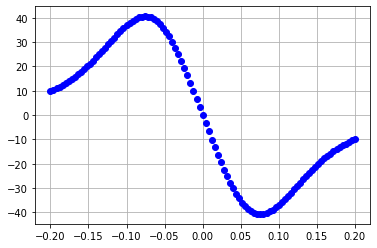

In [7]:
xs = np.linspace(-0.2,0.2,101)/x0
ys = np.linspace(-0.2,0.2,101)/x0

X,Y = np.meshgrid(xs,ys)



fig, ax = plt.subplots(1,1)
for Z in xs:
    ax.plot(Z*x0, Coil_field(5,np.array([Z,0,0]))[0],'bo')

ax.grid()

In [8]:
magfield = lambda R,t : Coil_field(5,R)

In [9]:
def Fixed_detune_MgF_MOT(main_det,det_1,det_2,beta_1,beta_2,laseron,laseroff,s,d1,d2,d3,d4,pol1,pol2,pol3,pol4):
    det_side = det_1/Gamma
    det_side2 = det_2/Gamma
    Avg_X = np.average(E_X)
    init_pow = 0.5*2./(np.pi*(0.012)**2)/Isat
    
    def Gaussian_Beam_Intensity(R,waist):
        return np.exp(-2*((R[0]-R[1])**2/2+R[2]**2)/waist**2)
    
    def Bessel_Intensity(n_order,beta):
        return special.jv(n_order,beta)**2
    
    def Heav_step(t):
        if laseron<=t and t<laseron+14:
            return -1*(t-laseron-7)*((t-laseron-7)**2-49*3)*1/686*1/2+1/2
        elif laseron+14<=t and t<laseroff:
            return 1
        elif t>=laseroff and t<laseroff+14:
            return (t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0
        
    
    laserBeams = pylcp.laserBeams()
# Minus Sideband part
    # matr = list()
    # for i in np.array([-1,0,1]):
    #     for j in np.array([-2,-1,0,1,2]):
    #         matr.append(pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side*i-det_side2*j,
    #                                                        's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Bessel_Intensity(i,beta_1)*Bessel_Intensity(j,beta_2)*Heav_step(t)},
    #                                                       {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side*i-det_side2*j,
    #                                                        's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Bessel_Intensity(i,beta_1)*Bessel_Intensity(j,beta_2)*Heav_step(t)}]))
    # for mat in matr:
    #     laserBeams +=mat
    # return laserBeams

                                        
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(2,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(0,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(-1,beta_1)*Bessel_Intensity(-2,beta_2)}])

# # Main Slowing Laser
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(2,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(0,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(0,beta_1)*Bessel_Intensity(-2,beta_2)}])
# # Plus Sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(2,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side-det_side2*0,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(0,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*1,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-1,beta_2)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,-1,0]),'pol':+1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)},
#                                     {'kvec':np.array([-1,-1,0]),'pol':-1,'pol_coord':'spherical','delta':(E_A[-1]-Avg_X-main_det)+det_side+det_side2*2,
#                                      's': lambda R,t : init_pow*Gaussian_Beam_Intensity(R,waist)*Heav_step(t)*Bessel_Intensity(1,beta_1)*Bessel_Intensity(-2,beta_2)}])
    
    def MOT_step(t):
        if laseroff<=t and t<laseroff+14:
            return -1*(t-laseroff-7)*((t-laseroff-7)**2-49*3)*1/686*1/2+1/2
        elif laseroff+14<=t:
            return 1
        else:
            return 0     
    
    def Gaussian_Beam_Axis(R,waist,ax):
        if ax==0:
            return np.exp(-2*(np.sum(R**2)-R[0]**2)/waist**2)
        elif ax==1:
            return np.exp(-2*(np.sum(R**2)-R[1]**2)/waist**2)
        elif ax==2:
            return np.exp(-2*(np.sum(R**2)-R[2]**2)/waist**2)


    for ii, Eg_i in enumerate(E_X):
        if ii==0:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol1,'delta':(E_A[-1]-Eg_i)+d1,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
        elif ii==1:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol2,'delta':(E_A[-1]-Eg_i)+d2,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}]) 
        elif ii==2:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol3,'delta':(E_A[-1]-Eg_i)+d3,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
        else:
            laserBeams += pylcp.laserBeams([{'kvec':np.array([1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([-1,0,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,0)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,-1,0]),'pol':-1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,1)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])
            laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':1*pol4,'delta':(E_A[-1]-Eg_i)+d4,
                                             's':lambda R,t : s*Gaussian_Beam_Axis(R,waist,2)*MOT_step(t)}])

    return laserBeams

In [10]:
laserBeams = Fixed_detune_MgF_MOT(main_detune,sideband_detune,white_detune,1,2,-50,-15,intensities,-2.5,0.22,-0.668,-0.4729,-1,-1,1,1)

In [11]:
zz = np.linspace(-1*0.020/x0,0.020/x0,100)
vv = np.linspace(-1*v_max,v_max,100)
Z,V = np.meshgrid(zz,vv)

rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [12]:
sols_rate = list()
z_eval = np.arange(-0.020,0.022,0.002)/x0
# v_eval = np.arange(v0_start,v0_end,v0_step)
t_eval = np.arange(t0_start,t0_end,t0_step)

start = time.time()

for z_pos in z_eval:
    rateeq.set_initial_position_and_velocity(np.array([-0.020/x0,-0.020/x0,z_pos]),np.array([5.810,5.810,0]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,max_step=np.inf,progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)
    
print(time.time()-start)

Completed in 3.64 s.                                                
Completed in 2.63 s.                                               
Completed in 2.73 s.                                               
Completed in 2.91 s.                                               
Completed in 2.86 s.                                                
Completed in 3.37 s.                                                
Completed in 3.68 s.                                                
Completed in 7.93 s.                                                 


KeyboardInterrupt: 

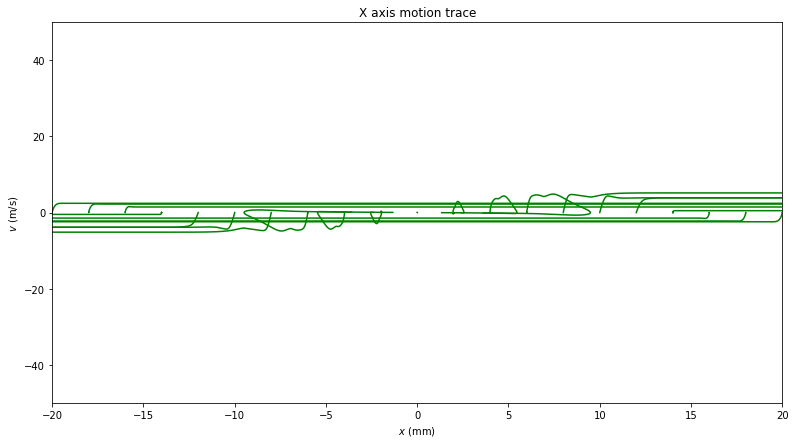

In [8]:
fig, ax = plt.subplots(1, 1,figsize=(13,7))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$x\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('X axis motion trace')
ax.set_xlim(-20,20)
ax.set_ylim(-50,50)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2]*x0*1000,sol.v[2]*v0, 'g')
    
# fig.savefig('./MOT/Error.png')
# fig.savefig('./MOT/No Error.png')

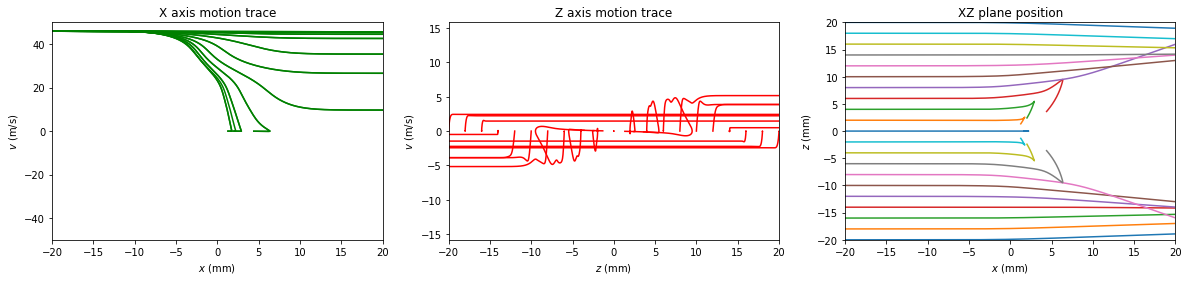

In [12]:
fig, ax = plt.subplots(1, 3,figsize=(20,4))
# plt.imshow(rateeq.profile['F'].F[0]/mass*1e-3*a0, origin='lower',
#            extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
#                    (np.amin(vv*v0)), (np.amax(vv*v0))),
#            aspect='auto',cmap='gray')
# cb1 = plt.colorbar()
# cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax[0].set_xlabel('$x\ (\mathrm{mm})$')
ax[0].set_ylabel('$v\ (\mathrm{m/s})$')
ax[0].set_title('X axis motion trace')
ax[0].set_xlim(-1*0.020*1000,0.020*1000)
ax[0].set_ylim(-50,50)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0, 'g')
    
ax[1].set_xlabel('$z\ (\mathrm{mm})$')
ax[1].set_ylabel('$v\ (\mathrm{m/s})$')
ax[1].set_title('Z axis motion trace')
ax[1].set_xlim(-1*0.020*1000,0.020*1000)
ax[1].set_ylim(-1*2*v0,2*v0)

for sol in sols_rate:
    ax[1].plot(sol.r[2]*x0*1000,sol.v[2]*v0,'r')
    
ax[2].set_xlabel('$x\ (\mathrm{mm})$')
ax[2].set_ylabel('$z\ (\mathrm{mm})$')
ax[2].set_title('XZ plane position')
ax[2].set_xlim(-1*0.020*1000,0.020*1000)
ax[2].set_ylim(-1*0.020*1000,0.020*1000)

for sol in sols_rate:
    ax[2].plot(sol.r[0]*x0*1000,sol.r[2]*x0*1000)

# fig.savefig('./Pictures/Z_position_result.png')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 39.97it/s]


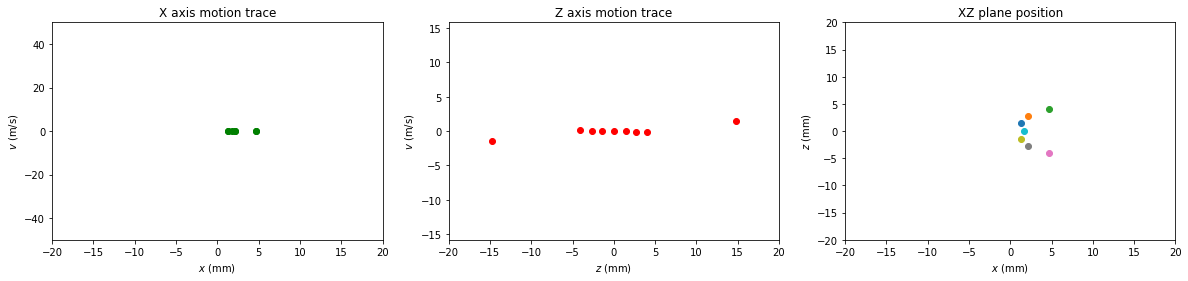

In [13]:
from matplotlib.animation import FuncAnimation
from celluloid import Camera

fig = plt.figure(figsize=(20,4))
ax=list()
for i in range(3):
    ax.append(fig.add_subplot(1,3,i+1))
camera = Camera(fig)

time_steps = np.arange(0,3000000,20000)

for time_step in tqdm(time_steps):
    ts = int(time_step)
    
    ax[0].set_xlabel('$x\ (\mathrm{mm})$')
    ax[0].set_ylabel('$v\ (\mathrm{m/s})$')
    ax[0].set_title('X axis motion trace')
    ax[0].set_xlim(-1*0.020*1000,0.020*1000)
    ax[0].set_ylim(-50,50)
    fig.subplots_adjust(left=0.12,right=0.9)

    for sol in sols_rate:
        ax[0].plot(sol.r[0][ts]*x0*1000,sol.v[0][ts]*v0, 'go')

    ax[1].set_xlabel('$z\ (\mathrm{mm})$')
    ax[1].set_ylabel('$v\ (\mathrm{m/s})$')
    ax[1].set_title('Z axis motion trace')
    ax[1].set_xlim(-1*0.020*1000,0.020*1000)
    ax[1].set_ylim(-1*2*v0,2*v0)

    for sol in sols_rate:
        ax[1].plot(sol.r[2][ts]*x0*1000,sol.v[2][ts]*v0,'ro')

    ax[2].set_xlabel('$x\ (\mathrm{mm})$')
    ax[2].set_ylabel('$z\ (\mathrm{mm})$')
    ax[2].set_title('XZ plane position')
    ax[2].set_xlim(-1*0.020*1000,0.020*1000)
    ax[2].set_ylim(-1*0.020*1000,0.020*1000)

    for sol in sols_rate:
        ax[2].plot(sol.r[0][ts]*x0*1000,sol.r[2][ts]*x0*1000,'o')
    camera.snap()
        
animation = camera.animate(interval=50, blit=True)

from IPython.display import HTML
HTML(animation.to_jshtml())

# animation.save('./Pictures/Motion Trace.gif',writer='imagemagick')